In [1]:
import numpy as np
import pandas as pd
import pretty_midi
import collections
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from IPython import display
import fluidsynth

%matplotlib inline
from matplotlib import pyplot as plt

# define dataset

In [2]:
class PianoRoll(Dataset):
    
    def __init__(self, df_meta: pd.DataFrame, seq_length: int = 25, 
                 batch_size: int = 20, batch_per_file=None):
        self.df_meta = df_meta.copy()

        self.df_meta['n_batches'] = (self.df_meta['roll_length'] - seq_length )*0.95 // batch_size
        self.df_meta['n_batches'] = self.df_meta['n_batches'].astype(int)
        file_idx_ends = []
        n_batches = self.df_meta['n_batches'].values
        file_idx_ends = [n_batches[0]*batch_size - 1]
        for batches_in_file in n_batches[1:]:
            file_idx_ends.append(batches_in_file*batch_size + file_idx_ends[-1] )

        self.df_meta['file_idx_ends'] = file_idx_ends

        
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.batch_per_file = batch_per_file

        if self.batch_per_file is not None:
            self.idx_per_file = self.batch_size*self.batch_per_file
        else:
            self.idx_per_file = None
        
        self.roll_cache = {}
        
    def __len__(self):
        if self.batch_per_file is None:
            return int(self.df_meta['n_batches'].sum()*self.batch_size)
        else:
            return self.df_meta.shape[0]*self.idx_per_file
    
    def __getitem__(self, idx):
        if self.batch_per_file is None:
            file_idx_ends = self.df_meta['file_idx_ends'].values
            for i in range(len(file_idx_ends)):
                if idx <= file_idx_ends[i]:
                    file_idx = i
                    break
            if file_idx == 0:
                idx_start = 0
            else:
                idx_start = file_idx_ends[file_idx - 1]
            window_idx = int(idx - idx_start)
        else:
            file_idx = idx // self.idx_per_file
            window_idx = idx % self.idx_per_file
        
        
        seq, label = self.get_rolls(file_idx, window_idx)
        
        seq = torch.from_numpy(seq).float()
        label = torch.from_numpy(label).float()
        return seq, label
    
    def midi_to_pianoroll(self, file, sample_dist=0.02):
        pm = pretty_midi.PrettyMIDI(file)
        
        sampling_rate = 1/sample_dist
        piano_roll = pm.get_piano_roll(fs=sampling_rate)
        return piano_roll
    
    def get_rolls(self, file_idx, window_idx):
        file_path = self.df_meta.iloc[file_idx]['file']
        
        if file_idx in self.roll_cache:
            roll = self.roll_cache[file_idx]
        else:
            note_dist = self.df_meta.iloc[file_idx]['16th_note_duration']
            roll = self.midi_to_pianoroll(file_path, sample_dist=note_dist)
            self.roll_cache[file_idx] = roll
            
        roll[roll != 0] = 1
        roll = roll.T
        roll_window = roll[window_idx:window_idx+self.seq_length+1, :]
        
        seq = roll_window[:-1]
        # seq[seq == 0] = -1
        label = roll_window[-1]
        return seq, label

# define model

In [3]:
class PianoRollLSTM(nn.Module):
    def __init__(self, hidden_size=64):
        super(PianoRollLSTM, self).__init__()
        
        input_size=128
        self.hidden_size = hidden_size
            
        self.lstm = nn.LSTM(input_size=input_size, batch_first=True, num_layers=1, hidden_size=hidden_size)
        
        self.norm = nn.BatchNorm1d(num_features=hidden_size)
        
        self.pitch_layer = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # xnorm = self.norm(x)
        output, (h_n, c_n) = self.lstm(x)
        linear_input = output[:, -1, :]
        normed_linear_input = self.norm(linear_input)
        left_output = self.pitch_layer(normed_linear_input)
        return left_output

# get a baseline

In [79]:
torch.manual_seed(0)
# set filepaths
print('i am running!', flush=True)
_reporoot = Path('/home/ian/projects/music-rnn')
# _reporoot = Path('/net/dali/home/mscbio/icd3/music-rnn')
_datadir = _reporoot / 'data' / 'classical'
_metadata_file = _datadir / 'metadata.csv'
output_dir = Path('./')
if not output_dir.exists():
    output_dir.mkdir()
metrics_file = output_dir / 'metrics.csv'

# fix filepaths in metadata according to given filepaths
df_meta = pd.read_csv(_metadata_file)
def process_path(row, _datadir=_datadir):
    fp = Path(row['file'])
    new_fp = _datadir / fp.name
    return str(new_fp)
df_meta['file'] = df_meta.apply(process_path, axis=1)

seq_length = 30
learning_rate = 3e-4
batch_size = 8
num_workers = 0
n_iters = 1000
out_interval = 200
hidden_size = 80

df_chpn = df_meta[df_meta['composer'] == 'chpn']
rng = np.random.default_rng(12345)
idx = np.arange(df_chpn.shape[0])
n_train = int(0.8*idx.shape[0])
train_idx = rng.choice(idx, size=n_train, replace=False)
test_idx = idx[~np.in1d(idx, train_idx)]
df_train = df_chpn.iloc[train_idx]
df_test = df_chpn.iloc[test_idx]

dset_train = PianoRoll(df_meta=df_train, 
                    batch_size=batch_size,
                    batch_per_file=None,
                    seq_length=seq_length)


dset_test = PianoRoll(df_meta=df_test, 
                    batch_size=batch_size, 
                    batch_per_file=20,
                    seq_length=seq_length)


train_dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dset_test, batch_size=batch_size, shuffle=False, num_workers=0)

model = PianoRollLSTM(hidden_size=hidden_size)
model.pitch_layer[0].bias = nn.Parameter(model.pitch_layer[0].bias - 0.24)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

metrics = collections.defaultdict(list)

iter_idx = -1
train_iterator = iter(train_dataloader)

train_losses = []

while iter_idx < n_iters:
    iter_idx += 1
    # print(f'iter_idx = {iter_idx}', flush=True)

    try:
        features, labels = next(train_iterator)
    except StopIteration:
        train_iterator = iter(train_dataloader)
        features, labels = next(train_iterator)
        
    # features = torch.zeros(features.shape)


    # compute prediction and loss
    # pred = model(features)[0, :, :]
    pred = model(features)
    loss = loss_fn(pred, labels)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())


    # compute metrics every 10 iterations
    if iter_idx % out_interval == 0:

        metrics['iter'].append(iter_idx)

        # compute train loss
        train_loss = np.mean(np.asarray(train_losses))
        metrics['train_loss'].append(train_loss)
        train_losses = []


        # test loop
        test_loss_fn = nn.BCELoss()
        test_loss = 0
        frac_notes_correct = 0
        frac_frames_correct = 0
        num_batches = len(test_dataloader)
        with torch.no_grad():
            for features, labels in test_dataloader:
                # pred = model(features)[0, :, :]
                pred = model(features)
                test_loss += test_loss_fn(pred, labels).item()

                notes = (pred > 0.5).type(torch.float)
                equal = torch.eq(notes, labels)
                frac_notes_correct += torch.mean(torch.sum(equal, axis=1) / 128)
                frac_frames_correct += torch.sum(torch.all(equal, axis=1)) / batch_size

        frac_notes_correct /= num_batches
        frac_frames_correct = frac_frames_correct / num_batches
        test_loss /= num_batches

        metrics['test_loss'].append(test_loss)
        metrics['frac_notes_correct'].append(frac_notes_correct)
        metrics['frac_frames_correct'].append(frac_frames_correct)

        # save metrics
        df_metrics = pd.DataFrame({ key: np.asarray(val) for key, val in metrics.items() })
        # df_metrics.to_csv(metrics_file)

        print(f'{iter_idx=}')

i am running!
iter_idx=0
iter_idx=200
iter_idx=400
iter_idx=600
iter_idx=800
iter_idx=1000


# viewing model model outputs

In [80]:
df_metrics

,iter,train_loss,test_loss,frac_notes_correct,frac_frames_correct
0,0,0.629102,0.618067,0.713867,0.00125
1,200,0.578249,0.543680,0.855898,0.00750
2,400,0.425127,0.328230,0.963916,0.03625
3,600,0.218628,0.173555,0.974336,0.05000
4,800,0.123855,0.122126,0.975264,0.04500
5,1000,0.090067,0.105280,0.975322,0.05125


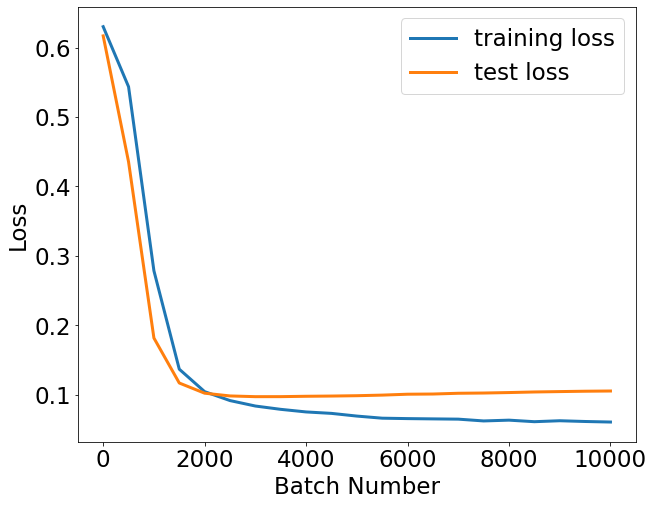

In [74]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["font.size"] = 23

plt.plot(df_metrics['iter'], df_metrics['train_loss'], label='training loss', linewidth=3)
plt.plot(df_metrics['iter'], df_metrics['test_loss'], label='test loss', linewidth=3)

plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

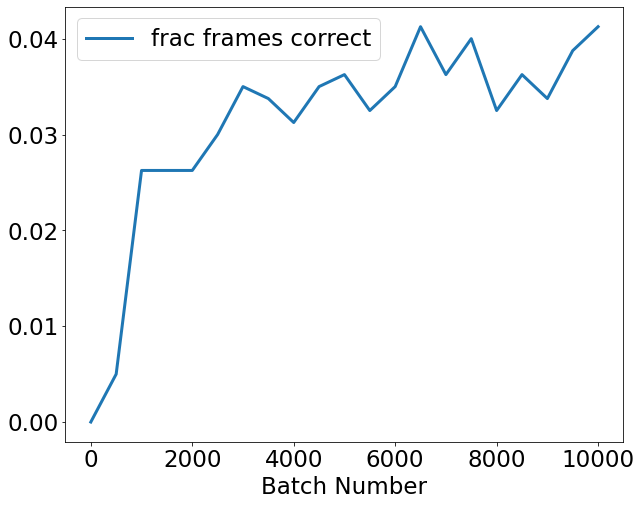

In [75]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["font.size"] = 23

# plt.plot(df_metrics['iter'], df_metrics['frac_notes_correct'], label='frac pitches correct', linewidth=3)
plt.plot(df_metrics['iter'], df_metrics['frac_frames_correct'], label='frac frames correct', linewidth=3)

plt.xlabel('Batch Number')
plt.ylabel('')
plt.legend()
plt.show()

In [11]:
from preprocess.process_output import pianoRoll_to_midi
_SAMPLING_RATE = 16000

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform= pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    # waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform, rate=_SAMPLING_RATE)

In [25]:
dset_test.df_meta.iloc[0]['file']

'/home/ian/projects/music-rnn/data/classical/chpn_op35_2.mid'

In [35]:
df_meta['composer'].unique()

array(['beethoven', 'schub', 'mz', 'burg', 'br', 'schumm-2', 'scn16',
       'schu', 'schuim-1', 'scn15', 'chpn', 'grieg', 'pathetique',
       'chpn-p15', 'chpn-p20', 'bk', 'gra', 'rac', 'alb', 'liz',
       'debussy', 'haydn', 'appass', 'ty', 'schubert', 'schumm-6', 'mond',
       'bach', 'muss', 'chpn-p16', 'schumm-4', 'clementi', 'chpn-p18',
       'chpn-p24', 'scn68', 'schumm-5', 'brahms', 'chpn-p22', 'schuim-4',
       'chpn-p4', 'elise', 'fruehlingsrauschen', 'mendel', 'mos',
       'chpn-p19', 'ravel', 'chp', 'hay', 'waldstein', 'god', 'chpn-p1',
       'bor', 'chpn-p9', 'deb', 'chpn-p13', 'rav', 'chpn-p5', 'chpn-p2',
       'chpn-p7', 'schumm-3', 'schuim-3', 'chpn-p23', 'schumm-1',
       'chpn-p14', 'chpn-p6', 'chpn-p12', 'chpn-p17', 'chpn-p8',
       'chpn-p3', 'chpn-p11', 'chpn-p21', 'islamei', 'schuim-2', 'schum',
       'chpn-p10'], dtype=object)

In [37]:
dset_val.df_meta

,file,composer,end_time,expected_tempo,16th_note_duration,roll_length,n_batches,file_idx_ends
2,/home/ian/projects/music-rnn/data/classical/mz...,mz,482.101321,189.367179,0.079211,6086,719,5751
69,/home/ian/projects/music-rnn/data/classical/mz...,mz,200.266750,236.270268,0.063487,3154,370,8711
88,/home/ian/projects/music-rnn/data/classical/mz...,mz,105.679197,189.863919,0.079004,1318,152,9927
104,/home/ian/projects/music-rnn/data/classical/mz...,mz,189.580079,253.238075,0.059233,3200,376,12935
107,/home/ian/projects/music-rnn/data/classical/mz...,mz,261.134004,260.630154,0.057553,4537,535,17215
109,/home/ian/projects/music-rnn/data/classical/mz...,mz,570.728809,225.234761,0.066597,8569,1014,25327
147,/home/ian/projects/music-rnn/data/classical/mz...,mz,537.763100,248.187384,0.060438,8897,1052,33743
150,/home/ian/projects/music-rnn/data/classical/mz...,mz,344.272009,213.270557,0.070333,4894,577,38359
158,/home/ian/projects/music-rnn/data/classical/mz...,mz,454.453007,157.278218,0.095372,4765,562,42855
170,/home/ian/projects/music-rnn/data/classical/mz...,mz,830.903229,207.036226,0.144902,5734,677,48271


In [81]:
df_val = df_meta[df_meta['composer'] == 'mz']

dset_val = PianoRoll(df_meta=df_val, 
                    batch_size=8,
                    batch_per_file=None,
                    seq_length=30)


next_frames = []
model.eval()
start_idx = 0
seq_len = 100
sequence, label = dset_test[start_idx]
with torch.no_grad():
    for idx in range(seq_len):
        # sequence, label = dset_test[start_idx + idx]
        pred = model(sequence.view(1, *sequence.shape))
        next_frame = (pred > 0.5).float()
        next_frames.append(next_frame)
        extended_sequence = torch.cat([sequence, next_frame], dim=0)
        sequence = extended_sequence[1:]

out = torch.cat(next_frames,dim=0)
out = np.asarray(out).astype(int)
df_proll = pd.DataFrame(out)
timestep = dset_test.df_meta.iloc[0]['16th_note_duration']

midi = pianoRoll_to_midi(df_proll, timestep=timestep)
display_audio(midi)

/home/ian/projects/music-rnn/preprocess/process_output.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  means[means==0]=pd.NA


In [82]:
out.sum(axis=1)

array([  9,  10,  14,  15,  16,  17,  30,  42, 104, 110, 125, 125, 126,
       126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126,
       126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126,
       126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126,
       126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126,
       126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126,
       126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126,
       126, 126, 126, 126, 126, 126, 126, 126, 126])

In [192]:
pd.DataFrame(out).to_csv('generated.csv', index=False)

# simple data